# Two Different Approaches in Text Mining
<br>
## Abstract

We will implement binary-class classification (positive sentiment vs. negative sentiment) based on text data on Yelp’s review dataset with two different approaches. The first approach is the standard __TF-IDF (Term Frequency - Inverse Document Frequency) matrix__ approach; We normalize text via case conversions, expanding contractions, removing special characters, removing stopwords etc. Then we construct a TF-IDF sparse matrix with true-labeled column and run supervised machine learning algorithms for binary-class classification. Another approach is a __Parsimonious Rule-Based Model for Sentiment Analysis__. We use an empirically constructed/validated gold-standard list of lexical features with their associated sentiment intensity measures. These features are combined with five general rules that embody grammatical and syntactical conventions, i.e., punctuation, capitalization, degree modifier, conjunction, and negation. We score each text/review with continuous polarity scores in range of [-1,1], where -1 represents extreme negative sentiment and 1 represents extreme positive sentiment. We investigate the performance of these two different approaches on different types of datasets, e.g., __Yelp review dataset (restaurant businesses only) vs. game review dataset__. By analyzing different performance results of two approaches on different topics of data, we reason advantages/disadvantages and limitations of each approach.

In [1]:
# packages needed
import numpy as np
import pandas as pd
import random
import json
import re
import matplotlib.pyplot as plt
import pylab as plt
import pickle
import nltk

## Yelp Review Dataset for Sentiment Analysis
### Data Collection
Conveniently, __Yelp__ has an open dataset @ https://www.yelp.com/dataset. One can simply one-click download *json* format review dataset. The dataset is called *review.json*, and it's saved in a local environment. We read this file and manipulate the dataset into pandas dataframe so that we can easily further manipulate/process/analyze.
<br>
<br>
Note: The variable *data* is a type of *list*, and the elements inside *data* consist of *bytes* and *dictionary*. We take this dictionary's keys as column vector and take its values as row vectors.

In [2]:
# Yelp Review Dataset
with open('review.json', 'rb') as f:
    review_data = f.readlines()

columns = list(json.loads(review_data[0]).keys())
rows = []
for i in range(0,len(review_data)):
    rows.append(list(json.loads(review_data[i]).values()))

review_data = pd.DataFrame(rows, columns=columns)

# Yelp Business Dataset
with open('business.json', 'rb') as f:
    business_data = f.readlines()

columns = list(json.loads(business_data[0]).keys())
rows = []
for i in range(0,len(business_data)):
    rows.append(list(json.loads(business_data[i]).values()))

business_data = pd.DataFrame(rows, columns=columns)

We check how many businesses are still open and operating.

In [3]:
# proportion of open businesses
np.sum(business_data['is_open']) / len(business_data)

0.8403764743622792

About 84% of businesses in the dataset are still operating. We truncate our data to the ones that are currently operating.

In [4]:
business_data = business_data[business_data.is_open == 1]

Now we merge two datasets above into one *Yelp_review*. We will analyze this *Yelp_review* for text mining. We truncate it to only include restaurant businesses. Also, we remove rows with null values and all columns we do not need.

We drop rows with null values, non-restaurant businesses, non-US/Canada/UK businesses.

In [5]:
Yelp_review = pd.merge(business_data, review_data, how='outer', on='business_id')

Yelp_review = Yelp_review[Yelp_review['name'].notnull()]
Yelp_review = Yelp_review[Yelp_review['categories'].notnull()]

def filter_restaurants(x):
    if 'Restaurants' in x:
        x = 1
    else:
        x = 0
    return x
Yelp_review['categories'] = np.vectorize(filter_restaurants)(Yelp_review['categories'])

Yelp_review = Yelp_review[Yelp_review['categories'] == 1]

Yelp_review = Yelp_review[(Yelp_review['state'] != '01') & (Yelp_review['state'] != '3') & (Yelp_review['state'] != '30')
           & (Yelp_review['state'] != '6') & (Yelp_review['state'] != 'B') & (Yelp_review['state'] != 'BW')
           & (Yelp_review['state'] != 'BY') & (Yelp_review['state'] != 'C') & (Yelp_review['state'] != 'HU')
           & (Yelp_review['state'] != 'NI') & (Yelp_review['state'] != 'VS')]

Yelp_review = Yelp_review[['text','stars_y']]
Yelp_review = Yelp_review.rename(columns={'text': 'review', 'stars_y': 'rating'})
Yelp_review = Yelp_review.reset_index(drop=True)
Yelp_review.head()

,review,rating
0,I've always enjoyed my time at brick house foo...,4
1,1st time here. Came w my Unc bc Louies was clo...,2
2,Worse service ever andI use to be a server so ...,1
3,I am updating my review to 5-stars because I t...,5
4,I enjoyed this place. I went the night the Bu...,4


First of all, let's check the distribution of rating.

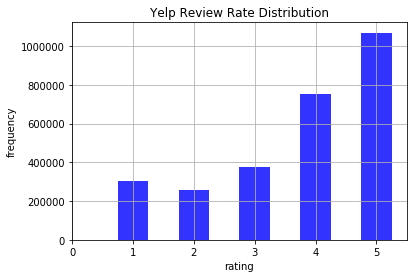

In [6]:
n, bins, patches = plt.hist(Yelp_review['rating'], align='left',
                            range=[0.5, 5.5], facecolor='blue', alpha=0.8)

plt.xlabel('rating')
plt.ylabel('frequency')
plt.title('Yelp Review Rate Distribution')
plt.grid(True)

plt.show()

We will remove 3-star rated reviews, because we don't think that 3-star reviews are a good represententative for negative or positive sentiment. More often than not, 3-star reviews show slightly more negative sentiments, but this highly depends on individual. For example, some give 3-stars thinking 3-stars are pretty bad, while others give 3-stars thinking 3-stars are slightly better than average. This is not representative and could be problematic. Furthermore, the proportion of 3-star rated reviews are relatively small, so it would not affect our training too much.

In [7]:
Yelp_review = Yelp_review[Yelp_review['rating'] != 3]

We define a *sentiment_classifier* function to create a new column *sentiment*. __1__ represents 'positive sentiment', and __0__ represents 'negative sentiment'.

In [8]:
def sentiment_classifier(x):
    if (x == 5) or (x == 4):
        y = 1
    else:
        y = 0
    return y
Yelp_review['sentiment'] = np.vectorize(sentiment_classifier)(Yelp_review['rating'])
Yelp_review.head()

,review,rating,sentiment
0,I've always enjoyed my time at brick house foo...,4,1
1,1st time here. Came w my Unc bc Louies was clo...,2,0
2,Worse service ever andI use to be a server so ...,1,0
3,I am updating my review to 5-stars because I t...,5,1
4,I enjoyed this place. I went the night the Bu...,4,1


Now we are good to go.

### 1. TF_IDF Matrix Approach
In general, text data are highly unstructured with little-to-no numeric values. This means that, with the current format, it is hard to apply most of machine learning algorithms, which typically require numerical inputs. In the __TF-IDF (Term Frequency - Inverse Document Frequency) matrix__, we clean and pre-process text column by case-conversion, expanding contractions, removing special characters, removing stopwords etc. Note that this part is probably the most time-consuming and also most important part of text mining. Even though we have a big dataset of over 2 million observations to train, without appropriate pre-processing, the results we get will likely be "bad".
<br>
<br>
Before we begin pre-processing, let's make a copy of the original data.

In [9]:
Yelp_review_original = Yelp_review.copy()

Again, we start with the distribution of sentiment distribution.

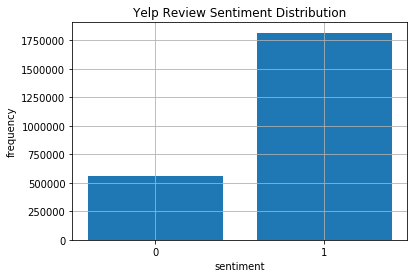

In [10]:
x = [1,2]
y = [Yelp_review[(Yelp_review['sentiment'] == 0)].count()[0],
     (len(Yelp_review)-Yelp_review[(Yelp_review['sentiment'] == 0)].count()[0])]

labels = list(np.unique(Yelp_review['sentiment']))

plt.bar(x, y, align='center')
plt.xticks(x, labels)
plt.xlabel('sentiment')
plt.ylabel('frequency')
plt.title('Yelp Review Sentiment Distribution')
plt.grid(True)
plt.show()

Data is a bit imbalanced. We will remedy this by randomly undersampling from the majority class (positive sentiment) without replacement. By doing this, we will lose some of potentially useful information, but that's a compromise we choose to make, considering we have big data.

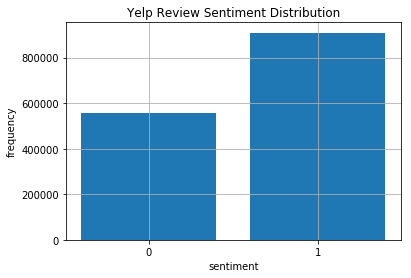

In [11]:
Yelp_review_pos = Yelp_review[Yelp_review['sentiment'] == 1]
Yelp_review_neg = Yelp_review[Yelp_review['sentiment'] == 0]

np.random.seed(1)
Yelp_review = pd.concat([Yelp_review_pos.sample(round(len(Yelp_review_pos)*0.5)), Yelp_review_neg])
Yelp_review = Yelp_review.reset_index(drop=True)

x = [1,2]
y = [Yelp_review[(Yelp_review['sentiment'] == 0)].count()[0],
     (len(Yelp_review)-Yelp_review[(Yelp_review['sentiment'] == 0)].count()[0])]

labels = list(np.unique(Yelp_review['sentiment']))

plt.bar(x, y, align='center')
plt.xticks(x, labels)
plt.xlabel('sentiment')
plt.ylabel('frequency')
plt.title('Yelp Review Sentiment Distribution')
plt.grid(True)
plt.show()

Data look more or less balanced now.
<br>
<br>
Since we can't get new data with the same format, we will put aside *test dataset*. After pre-processing and training on the rest dataset, i.e. *train dataset*, we will test our model on the *test dataset* in the end, and that will be our performance metric. We choose to put aside 20% of data as a test dataset.

In [12]:
# train / test set split
np.random.seed(1)
indices = Yelp_review.index.tolist()
np.random.shuffle(indices)

train_indices = indices[:int(len(Yelp_review)*0.8)]
test_indices = indices[int(len(Yelp_review)*0.8):]

Yelp_review_train = Yelp_review.iloc[train_indices,:].reset_index(drop=True)
Yelp_review_test = Yelp_review.iloc[test_indices,:].reset_index(drop=True)

### Pre-processing

#### 1) Case conversion
Our first pre-processing task is converting every character to lower case. We assume that there is no significant difference between uppercase words and lowercase words, i.e., the word *__Her__* does not have a significant difference in meaning whether it's used as *"__Her__ dog was sick"* or as *"I like __her__ dog"*. With this assumption, there's no reason for us to consider *Her* and *her* as two different unique words.

In [13]:
#Yelp_review_train['converted_review'] = Yelp_review_train['review'].str.lower()
#converted_review = list(Yelp_review_train['converted_review'])
#Yelp_review_train.head()

,review,rating,sentiment,converted_review
0,"Me and my Wife wanted to try this place once, ...",2,0,"me and my wife wanted to try this place once, ..."
1,Best Mexican food ever! Has a very comforting ...,5,1,best mexican food ever! has a very comforting ...
2,Want to thank Hong for her great customer serv...,5,1,want to thank hong for her great customer serv...
3,Absolutely delicious!\nI am a big fan of afgha...,4,1,absolutely delicious!\ni am a big fan of afgha...
4,"Fast service, big portions, clean restaurant. ...",5,1,"fast service, big portions, clean restaurant. ..."


#### 2) Expanding contractions
<br>
Contractions such as *"I'm"*, *"you're"*, *"they're"* will be expanded to the formal form of *"I am"*, *"you are"*, *"they are"*. The reason we do this is that there is no difference at all between *"I am"* and *"I'm"* semantically, but when we tokenize them, they will be separated as different tokens, which is not a meaningful separation.
<br>
<br>
Ambiguous contractions can be a problem here, though. There are some contractions that can have multiple meanings, which means that, without context, it will be hard to determine which means which. For example, *"he'd"* could be either *"he would"* or *"he had"*. Also, *"ain't"* could be either *"am not"* or *"are not"*. But if we think about it, this ambiguity does not play a major role for our purpose, sentiment analysis. Because these examples show little to no information about one's opinions. What matters is *"not"* and a verb that follows. And in case of *"he'll"* => *"he will"* or *"he shall"*, we simply choose *"he will"* since *"he shall"* is a rare expression, and we will remove a certain percentage of the least frequent tokens later anyway.

In [13]:
#contraction_dict = { 
#"ain't": "am not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
#"couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
#"hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
#"how'll": "how will", "how's": "how is", "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
#"isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us", "might've": "might have",
#"mightn't": "might not", "must've": "must have", "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not",
#"shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have",
#"shouldn't": "should not", "that'd": "that would", "that's": "that is", "there'd": "there would", "there's": "there is",
#"they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
#"we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
#"what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
#"where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who's": "who is",
#"who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
#"would've": "would have", "wouldn't": "would not", "y'all": "you all", "you'd": "you would", "you'll": "you will",
#"you're": "you are", "you've": "you have"
#}
#
#contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
#def expand_contractions(s, contraction_dict=contraction_dict):
#     def replace(match):
#         return contraction_dict[match.group(0)]
#     return contraction_re.sub(replace, s)
#    
#for i in range(0,len(converted_review)):
#    converted_review[i] = expand_contractions(converted_review[i])

#### 3) Removing Special Characters
Often punctuation or special characters do not have much significance when we analyze the text and utilize it for extracting features or information based on NLP and ML.

In [14]:
#def remove_special_characters(sentence, keep_apostrophes=False):
#    sentence = sentence.strip()
#    if keep_apostrophes:
#        PATTERN = r'[!|?|$|&|*|%|@|(|)|~|#|^|-|_|+|=]' # add other characters here to remove them
#        filtered_sentence = re.sub(PATTERN, r'', sentence)
#    else:
#        PATTERN = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
#        filtered_sentence = re.sub(PATTERN, r'', sentence)
#    return filtered_sentence
#
#converted_review = [remove_special_characters(sentence) for sentence in converted_review]

#### 4) Lemmatization
Lemmatization is very time-consuming process. For the simplicity, we skip lemmatization. In fact, TF-IDF model turned out to be pretty good without lemmatization.

In [16]:
#from nltk.stem import WordNetLemmatizer
#from nltk import pos_tag
#from nltk.corpus import wordnet as wn
#nltk.download(['averaged_perceptron_tagger','universal_tagset','wordnet'])

#wnl = WordNetLemmatizer()

#def tokenize_text(text):
#    tokens = nltk.word_tokenize(text) 
#    tokens = [token.strip() for token in tokens]
#    return tokens

### Annotate text tokens with POS tags
#def pos_tag_text(text):
    
#    def penn_to_wn_tags(pos_tag):
#        if pos_tag.startswith('J'):
#            return wn.ADJ
#        elif pos_tag.startswith('V'):
#            return wn.VERB
#        elif pos_tag.startswith('N'):
#            return wn.NOUN
#        elif pos_tag.startswith('R'):
#            return wn.ADV
#        else:
#            return None

#    tagged_text = pos_tag(text)
#    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag)) for word, pos_tag in tagged_text]
#    return tagged_lower_text

### lemmatize text based on POS tags 
#def lemmatize_text(text):
#    text = tokenize_text(text)
#    pos_tagged_text = pos_tag_text(text)
#    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
#                         else word                     
#                         for word, pos_tag in pos_tagged_text]
#    lemmatized_text = ' '.join(lemmatized_tokens)
#    return lemmatized_text

#converted_review = [lemmatize_text(sentence) for sentence in converted_review]

Now we add a new column *converted_review* to the train data. Then we pickle *Yelp_review_train* dataset.

In [15]:
#Yelp_review_train['converted_review'] = pd.Series(converted_review)

#pickle.dump(Yelp_review_train, open('Yelp_review_train.pkl', 'wb'))
Yelp_review_train = pickle.load(open('Yelp_review_train.pkl', 'rb'))
Yelp_review_train.head(10)

,review,rating,sentiment,converted_review
0,"Me and my Wife wanted to try this place once, ...",2,0,me and my wife wanted to try this place once i...
1,Best Mexican food ever! Has a very comforting ...,5,1,best mexican food ever has a very comforting e...
2,Want to thank Hong for her great customer serv...,5,1,want to thank hong for her great customer serv...
3,Absolutely delicious!\nI am a big fan of afgha...,4,1,absolutely deliciousi am a big fan of afghani ...
4,"Fast service, big portions, clean restaurant. ...",5,1,fast service big portions clean restaurant gre...
5,Nobu should add three letters to the end of it...,1,0,nobu should add three letters to the end of it...
6,"The pictures don't do this place justice, the ...",5,1,the pictures do not do this place justice the ...
7,My family and I visit this restaurant often. T...,1,0,my family and i visit this restaurant often to...
8,"Hands down, far and away, the best deli in Dan...",5,1,hands down far and away the best deli in dane ...
9,"Disgusting, it started off with the lady worki...",1,0,disgusting it started off with the lady workin...


#### 4) Tokenization / Parameter Tuning
We wanted to fine-tune parameters for *TfidfVectorizer* and *RandomForestClassifier*, but it just takes too much time, which causes kernel death. So, we skip this step.

In [18]:
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.ensemble import RandomForestClassifier

#tfidf_vectorizer = TfidfVectorizer()
#rf_classifier = RandomForestClassifier()

# random forest classifier
#pipeline = Pipeline([('vect', tfidf_vectorizer),('clf', rf_classifier)])
#param_grid = [{
#              'vect__analyzer': ['word'],
#              'vect__max_df': [0.8,0.85,0.9],
#              'vect__min_df': [0.01,0.05,0.1],
#              'vect__stop_words': ['english'],
#              'clf__n_estimators': [10,30,50]
#               }
#              ]
#gridsearch = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=20)
#gridresult = gridsearch.fit(Yelp_review_train['converted_review'], Yelp_review_train['sentiment'])
#gridresult.best_params_
#gridresult.best_score_

We combine stopwords from both *sklearn.feature_extraction* and *nltk.corpus*.

In [16]:
# construct stop_words_set (sklearn built-in list + nltk list)
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

stop_words_set = list(list(stop_words.ENGLISH_STOP_WORDS) + stopwords.words('english'))
stop_words_set = list(np.unique(stop_words_set))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emericszaboky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


By using TfidfVectorizer fucntion, we extract a TF-IDF sparse matrix. We use the stopwords set created above, and tune *max_df* and *min_df* parameters to cut off too (in)frequent terms. We chose *max_df = 0.8* and *min_df = 0.01* based on a few trials on a separate environment where kernel does not die. We pickled *Yelp_tfidf_vect_fit* with these parameters.

In [17]:
# construct TF-IDF Matrix with true label column
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=stop_words_set, max_df=0.8, min_df=0.01)
#Yelp_tfidf_vect_fit = tfidf_vectorizer.fit(Yelp_review_train['converted_review'])
#pickle.dump(Yelp_tfidf_vect_fit, open('Yelp_tfidf_vect_fit.pkl', 'wb'))
Yelp_tfidf_vect_fit = pickle.load(open('Yelp_tfidf_vect_fit.pkl', 'rb'))
tfidf_sparse = Yelp_tfidf_vect_fit.transform(Yelp_review_train['converted_review'])
tfidf_dense = tfidf_sparse.todense(order=None, out=None)
tfidf_dense = pd.DataFrame(tfidf_dense)
tfidf_dense['y'] = Yelp_review_train['sentiment']
tfidf_dense.head(10)

,0,1,2,3,4,5,6,7,8,9,...,741,742,743,744,745,746,747,748,749,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


The following is the vocabulary list (predictors) that we use to predict the sentiment of reviews.

In [18]:
np.sort(list(Yelp_tfidf_vect_fit.vocabulary_.keys()))

array(['10', '12', '15', '20', '25', '30', '40', '45', 'able',
       'absolutely', 'actually', 'add', 'added', 'ago', 'ahead',
       'amazing', 'ambiance', 'apparently', 'appetizer', 'appetizers',
       'area', 'arrived', 'asian', 'ask', 'asked', 'asking', 'ate',
       'atmosphere', 'attention', 'attentive', 'attitude', 'authentic',
       'available', 'average', 'avocado', 'avoid', 'away', 'awesome',
       'awful', 'bacon', 'bad', 'baked', 'bar', 'barely', 'bartender',
       'based', 'basically', 'bbq', 'beans', 'beautiful', 'beef', 'beer',
       'beers', 'believe', 'best', 'better', 'big', 'birthday', 'bit',
       'bite', 'black', 'bland', 'bottle', 'bowl', 'box', 'boyfriend',
       'bread', 'breakfast', 'bring', 'broth', 'brought', 'brunch',
       'buffet', 'bun', 'burger', 'burgers', 'burrito', 'business',
       'busy', 'butter', 'buy', 'cafe', 'cake', 'called', 'came', 'card',
       'care', 'case', 'cash', 'casual', 'certainly', 'chain', 'chance',
       'change', 'cha

We can also check the weights ("importance") of each word in the dictionary, but it is hard to see why these words are important in classifying sentiment. 

In [19]:
term_weights = pd.DataFrame(Yelp_tfidf_vect_fit.idf_, np.sort(list(Yelp_tfidf_vect_fit.vocabulary_.keys())))
term_weights = term_weights.rename(columns={0: 'weights'})
top_term_weights = term_weights.sort_values(by=['weights'], ascending=False).head(15)
bot_term_weights = term_weights.sort_values(by=['weights'], ascending=True).head(15)
top_term_weights

,weights
cash,5.604475
apparently,5.604475
surprise,5.599551
ahead,5.597098
delivered,5.596929
hate,5.593220
sort,5.593052
speak,5.592379
rating,5.591119
avocado,5.587263


We implement a random forest machine learning algorithm on this *tfidf_dense* matrix. We use 5-fold cross validation to see if RandomForestClassifier with default parameter setting works well. This also takes a very long time, so we will not run it here, but the 5-fold cross validation average accuracy we obtained was 0.886 with 0.88610402,  0.88555484,  0.88674614,  0.8866316 ,  0.88601483 for each iteration.

In [20]:
### computation of 5-fold cross validation score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
#kfold = model_selection.KFold(n_splits=5, random_state=1, shuffle=True) # 5 fold CV
#modelCV = RandomForestClassifier()
#scoring = 'accuracy'
#tfidf_dense_X = tfidf_dense.iloc[:,:-1]
#tfidf_dense_y = tfidf_dense.iloc[:,-1]
#results = model_selection.cross_val_score(modelCV, tfidf_dense_X, tfidf_dense_y, cv=kfold, scoring=scoring)
#print("5-fold cross validation average accuracy: %.3f" % (results.mean()))

We fit random forest classifier on train data. And again, we pickled this random forest fit as *Yelp_tfidf_rf_fit.pkl*.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf_classifier = RandomForestClassifier()

tfidf_dense_X = tfidf_dense.iloc[:,:-1]
tfidf_dense_y = tfidf_dense.iloc[:,-1]

np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(tfidf_dense_X, tfidf_dense_y, test_size=0.2)
#Yelp_tfidf_rf_fit = rf_classifier.fit(X_train, y_train)
#pickle.dump(Yelp_tfidf_rf_fit, open('Yelp_tfidf_rf_fit.pkl', 'wb'))
Yelp_tfidf_rf_fit = pickle.load(open('Yelp_tfidf_rf_fit.pkl', 'rb'))

Let's compute some basic scores.

In [22]:
# misclassification rate
len(np.where(y_test != Yelp_tfidf_rf_fit.predict(X_test))[0]) / len(y_test)

0.11129325504455903

In [23]:
# mean accuracy of the model
Yelp_tfidf_rf_fit.score(X_test, y_test)

0.888706744955441

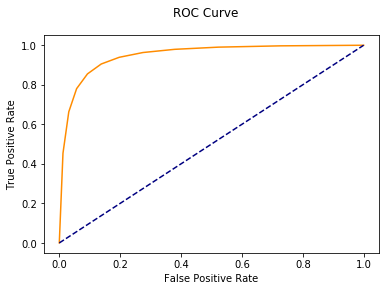

In [24]:
# ROC curve
from sklearn import metrics
prob_value = Yelp_tfidf_rf_fit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_value)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.suptitle('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [25]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, Yelp_tfidf_rf_fit.predict(X_test))

0.8836601521441947

In [26]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_test, Yelp_tfidf_rf_fit.predict(X_test), average='weighted')

0.8888654312395818

Now we apply our model to the test set. Again, we use pickle.

In [27]:
# transform text data in test set
#Yelp_review_test['converted_review'] = Yelp_review_test['review'].str.lower()
#converted_review = list(Yelp_review_test['converted_review'])
#converted_review = [remove_special_characters(sentence) for sentence in converted_review]
#Yelp_review_test['converted_review'] = pd.Series(converted_review)

#pickle.dump(Yelp_review_test, open('Yelp_review_test.pkl', 'wb'))
Yelp_review_test = pickle.load(open('Yelp_review_test.pkl', 'rb'))

In [28]:
# construct TF-IDF matrix with true label column
tfidf_sparse = Yelp_tfidf_vect_fit.transform(Yelp_review_test['converted_review'])
tfidf_dense = tfidf_sparse.todense(order=None, out=None)
tfidf_dense = pd.DataFrame(tfidf_dense)
tfidf_dense['y'] = Yelp_review_test['sentiment']

In [29]:
# misclassification rate
X_test = tfidf_dense.iloc[:,:-1]
y_test = tfidf_dense.iloc[:,-1]
len(np.where(y_test != Yelp_tfidf_rf_fit.predict(X_test))[0]) / len(y_test)

0.11209554077207899

In [30]:
# mean accuracy of the model
Yelp_tfidf_rf_fit.score(X_test, y_test)

0.887904459227921

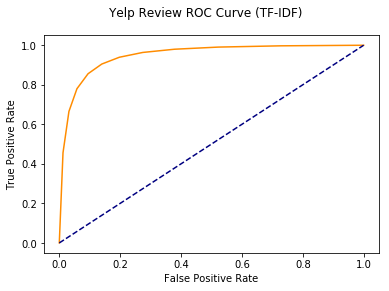

In [31]:
# ROC curve
prob_value = Yelp_tfidf_rf_fit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_value)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.suptitle('Yelp Review ROC Curve (TF-IDF)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
# AUC
roc_auc_score(y_test, Yelp_tfidf_rf_fit.predict(X_test))

0.88263261072467

In [33]:
# F1 score
f1_score(y_test, Yelp_tfidf_rf_fit.predict(X_test), average='weighted')

0.8880565951422523

### 1.1 Further Investigation on TF-IDF Model
Since random forest classifier is a sort of black-box model, it is not easy to dig deeper inside the model. We choose to try topic modeling on misclassified (false positive and false negative separately) reviews. Firstly, we pickle false positive and false negative reviews into *review_fp* and *review_fn*.

In [34]:
misclass_indices = np.where(y_test != Yelp_tfidf_rf_fit.predict(X_test))[0]

review_misclass_indices = y_test.index[misclass_indices].tolist()
review_misclass = Yelp_review_test.iloc[review_misclass_indices]

review_fp = review_misclass[review_misclass['sentiment'] == 0]
review_fn = review_misclass[review_misclass['sentiment'] == 1]

### 1.1.1 False Positive
We look into randomly picked 2000 reviews instead of the entire false positive reviews for simplicity.

In [35]:
tmp_indices = review_fp.index.tolist()
np.random.seed(1)
np.random.shuffle(tmp_indices)

tmp_indices = tmp_indices[0:2000]
sub_review = review_fp.loc[tmp_indices,:].reset_index(drop=True)

In [36]:
#! wget https://raw.githubusercontent.com/dipanjanS/text-analytics-with-python/master/Chapter-4/feature_extractors.py

The following code is to get the matrix X that will be used for non-negative matrix factorization.

In [37]:
nltk.download('punkt')

def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

stop_words_set = list(list(ENGLISH_STOP_WORDS) + stopwords.words('english'))
stop_words_set = list(np.unique(stop_words_set))

def remove_stopwords(text,stopword_list):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

text = [remove_stopwords(rev, stop_words_set) for rev in sub_review['converted_review']]

from feature_extractors import tfidf_transformer
from feature_extractors import bow_extractor    

def tf_idf(corpus):
    # Bag of words construction
    bow_vectorizer, bow_features = bow_extractor(corpus=corpus)
    # feature names
    feature_names = bow_vectorizer.get_feature_names()
    # TF-IDF    
    tfidf_trans, tdidf_features = tfidf_transformer(bow_features)
    tdidf_features = np.round(tdidf_features.todense(),2)
    return((tdidf_features, feature_names))

tdidf_features,feature_names = tf_idf(text)

X = tdidf_features.T

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emericszaboky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


For non-negative matrix factorization, we choose r to be 10.

In [38]:
# Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

r = 10
W_topic10,H_topic10 = \
    non_negative_marix_decomp(n_components = r, train_data = X) 

H_topic10 /= H_topic10.sum(0)

num_top_words = 10
num_topics = 10
word_topic = W_topic10
fontsize_base = 15

for t in range(0, num_topics):
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = [feature_names[k] for k in top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    print('# Topic', t)
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        print(word, share)
    print('\n')

# Topic 0
food 1.066081825588413
service 0.49925823066758734
good 0.4877379443716262
great 0.4230215181296991
staff 0.20460309375244307
friendly 0.17054883198290918
better 0.13440489814553155
restaurant 0.13420149948212026
price 0.12840112451387978
atmosphere 0.12800513573903327


# Topic 1
pizza 1.709761501703577
crust 0.22727112067242072
sauce 0.1815319197699793
cheese 0.17731664462731106
toppings 0.17515073768884246
like 0.1298292512873122
slice 0.12824749687858575
dough 0.12149996547107188
pepperoni 0.11905042708400833
wings 0.11896575703537891


# Topic 2
chicken 1.199311407479641
sauce 0.5724694771693698
fried 0.36446244508213715
wings 0.2949682452136524
ordered 0.287116439016356
pork 0.2832953953083347
taste 0.2749997795414955
rice 0.2654996609909071
soup 0.25429783953938245
meat 0.25376289199250385


# Topic 3
place 1.29478370362165
like 0.3216713419056933
really 0.22641948483580515
dont 0.20656905636011716
great 0.2034310538957205
eat 0.19309074530074397
breakfast 0.1749211107

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Most of the topics are related to the type of restaurants, but if we look at *Topic 0*, *Topic 3*, *Topic 7*, and *Topic 9*, they include positive words such as *good*, *great*, *better*, *quality*, *fresh*. This might be an indicator of misclassification, but we can't say for sure since negation (not, don't etc.) can flip the sentiment.

### 1.1.2 False Negative
We repeat the procedure above for false negative reviews.

In [39]:
tmp_indices = review_fn.index.tolist()
np.random.seed(1)
np.random.shuffle(tmp_indices)

tmp_indices = tmp_indices[0:2000]
sub_review = review_fn.loc[tmp_indices,:].reset_index(drop=True)

text = [remove_stopwords(rev, stop_words_set) for rev in sub_review['converted_review']]
tdidf_features,feature_names = tf_idf(text)
X = tdidf_features.T

r = 10
W_topic10,H_topic10 = \
    non_negative_marix_decomp(n_components = r, train_data = X) 

H_topic10 /= H_topic10.sum(0)

num_top_words = 10
num_topics = 10
word_topic = W_topic10
fontsize_base = 15# / np.max(word_topic) # font size for word with largest share in corpus

for t in range(0, num_topics):
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = [feature_names[k] for k in top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    print('# Topic', t)
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        print(word, share)
    print('\n')

# Topic 0
table 0.25433325212419444
restaurant 0.2528171162287662
came 0.2456164567406311
bar 0.2366673311218002
ordered 0.2260807524167055
server 0.21894224840759446
drinks 0.20661108170277104
great 0.18970144813546103
asked 0.18836769745380078
didnt 0.18629341335732172


# Topic 1
pizza 1.780274403616758
crust 0.24336272910801945
slice 0.194316333475038
cheese 0.15219955791727927
pizzas 0.1453377500591485
good 0.13722956260923083
sauce 0.10786798684977239
order 0.09772462316600841
new 0.09319480214206301
time 0.09073402260454079


# Topic 2
chicken 0.942027290780795
rice 0.5282997995446332
fried 0.4846513595199624
spicy 0.412751960108937
ordered 0.27182110057738784
soup 0.26915219793700246
sauce 0.24753075496527877
good 0.22649208683921604
lunch 0.21655444687994765
hot 0.20654045314988195


# Topic 3
pho 1.1947873939175477
spring 0.23324383653808484
broth 0.22054649555248926
rolls 0.1572734157481466
soup 0.15649445761388708
pork 0.12500591131946698
vietnamese 0.11703231769270422
plac

In false negative reviews, it's even less clear. All the topics have positive words except "didn't" from *Topic 0*. This is not really helpful since it does not show any clue why these reviews were classified as negative. Clearly, it is not easy to break __TF-IDF Model__ down and investigate on what could possibly attribute misclassification.

### 2. Parsimonious Rule-Based Model Approach
Traditional machine learning algorithms take a lot of computational power for training data or parameter tuning. __Parsimonious Rule-Based Model__ is very different from TF-IDF matrix approach in many ways. First of all, it uses a gold-standard sentiment lexicon built from existing human-validated sentiment lexicons and evaluating the impact of grammatical/syntactical rules. Also, it uses data-driven iterative inductive coding analysis to identify generalizable heuristics for assessing sentiment in text. Thus, it requires no training data, which implies it is computationally effcient, yet the performance we obtained was not too far off from our __TF-IDF__ model.

In [39]:
VADER_Yelp_review = Yelp_review_test.copy()

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
#def sentiment_analyzer(x):
#    x = analyzer.polarity_scores(x).get('compound')
#    return x
#VADER_Yelp_review['polarity_score'] = np.vectorize(sentiment_analyzer)(VADER_Yelp_review['review'])

In [41]:
#def normalize(x):
#    x = (x+1)/2
#    return x
#VADER_Yelp_review['normalized_polarity_score'] = np.vectorize(normalize)(VADER_Yelp_review['polarity_score'])
#
#def VADER_sentiment(x):
#    if x > 0.5:
#        y = 1
#    elif x == 0.5:
#        if np.random.uniform(0,1) >= 0.5:
#            y = 1
#        else:
#            y = 0
#    else:
#        y = 0
#    return y
#VADER_Yelp_review['predicted_sentiment'] = np.vectorize(VADER_sentiment)(VADER_Yelp_review['normalized_polarity_score'])

In [42]:
#pickle.dump(VADER_Yelp_review, open('VADER_Yelp_review.pkl', 'wb'))
VADER_Yelp_review = pickle.load(open('VADER_Yelp_review.pkl', 'rb'))
VADER_Yelp_review.head(10)

,review,rating,sentiment,converted_review,polarity_score,normalized_polarity_score,predicted_sentiment
0,Walked here from staying at the Trump Towers a...,4,1,walked here from staying at the trump towers a...,0.8758,0.93790,1
1,I loved watching Koi Poke come to life. The d...,5,1,i loved watching koi poke come to life the de...,0.9813,0.99065,1
2,We have been coming here since they opened and...,5,1,we have been coming here since they opened and...,0.9971,0.99855,1
3,Oh Scott!! When is the last time you did quali...,2,0,oh scott when is the last time you did quality...,-0.9222,0.03890,0
4,I went here with a large group for a friend's ...,4,1,i went here with a large group for a friends b...,0.9907,0.99535,1
5,One star for conceive and well cooked veggies....,1,0,one star for conceive and well cooked veggies ...,-0.9879,0.00605,0
6,This is all around less than mediocre Mexican ...,1,0,this is all around less than mediocre mexican ...,0.7362,0.86810,1
7,My family loves this place. Everyone gets thei...,5,1,my family loves this place everyone gets their...,0.9245,0.96225,1
8,"Where do I begin, already having a bad hotel s...",2,0,where do i begin already having a bad hotel st...,-0.5946,0.20270,0
9,"The place is awesome, bartenders are amazing. ...",5,1,the place is awesome bartenders are amazing hi...,0.9500,0.97500,1


In [43]:
# misclassification rate
len(np.where(VADER_Yelp_review['sentiment'] != VADER_Yelp_review['predicted_sentiment'])[0]) / len(VADER_Yelp_review)

0.21331807297042282

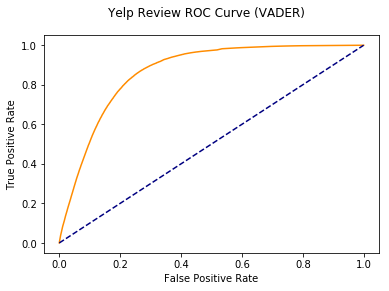

In [44]:
# ROC curve
prob_value = VADER_Yelp_review['normalized_polarity_score']
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_value)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.suptitle('Yelp Review ROC Curve (VADER)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [45]:
y_true = list(VADER_Yelp_review['sentiment'])
y_pred = list(VADER_Yelp_review['predicted_sentiment'])

In [46]:
# AUC
roc_auc_score(y_true, y_pred)

0.7269024881791688

In [47]:
# F1 score
f1_score(y_true, y_pred, average='weighted')

0.7659532951243083

We put scores of the two different models into a single table.

<br>

|          |  Yelp Review (TF-IDF)  | Yelp Review (VADER) |
|:-------------:|:-------------:|:----------------:|
|   error rate  |     0.112     |      0.213       |
|      AUC      |     0.883     |      0.727       |
| F1 (weighted) |     0.888     |      0.766       |
<br>
<br>

Clearly, __TF-IDF__ model is better in every aspect in terms of scores. But still we have to admit that the computational efficiency of __Parsimonious Rule-Based Model__ is much better than __TF-IDF__.

### 2.1 Further Investigation on Parsimonious Rule-Based Model

So far, we've obtained some scores to compare each model. This time, we look into more details about each misclassified review, more specifically, *badly* misclassified reviews.

In [48]:
misclassified_Yelp_review = VADER_Yelp_review[VADER_Yelp_review['sentiment'] != VADER_Yelp_review['predicted_sentiment']]
badly_misclassified_Yelp_review = misclassified_Yelp_review[misclassified_Yelp_review['rating'] == 1]
badly_misclassified_Yelp_review = badly_misclassified_Yelp_review[badly_misclassified_Yelp_review['normalized_polarity_score'] > 0.95]
badly_misclassified_Yelp_review.head(10)

,review,rating,sentiment,converted_review,polarity_score,normalized_polarity_score,predicted_sentiment
92,This is a first and hopefully the last single ...,1,0,this is a first and hopefully the last single ...,0.9812,0.99060,1
100,"IMHO, this used to be one of my favorite steak...",1,0,imho this used to be one of my favorite steak ...,0.9503,0.97515,1
124,They have two managers working today and the o...,1,0,they have two managers working today and the o...,0.9096,0.95480,1
171,I saw this place on the food networks with guy...,1,0,i saw this place on the food networks with guy...,0.9852,0.99260,1
188,This is concerning Caraoke only. I got there 9...,1,0,this is concerning caraoke only i got there 93...,0.9020,0.95100,1
192,Went to Uno for lunch on a work day. I have b...,1,0,went to uno for lunch on a work day i have be...,0.9740,0.98700,1
212,Well it starts off with an 8 pm reservation ...,1,0,well it starts off with an 8 pm reservation ...,0.9724,0.98620,1
229,"Wow, what a disappointment. This is rated the...",1,0,wow what a disappointment this is rated the 3...,0.9846,0.99230,1
241,A little background information: we went on Su...,1,0,a little background information we went on sun...,0.9832,0.99160,1
457,Great if you are into drunk MILFs! Hang on to ...,1,0,great if you are into drunk milfs hang on to t...,0.9151,0.95755,1


We can see that these reviews are not just misclassified, but their polarity scores are extremely high while the correspoding reviews are very negative. Let's take a closer look at a couple of reviews that are *badly* misclassfied.

__Example 1__

In [50]:
badly_misclassified_Yelp_review.iloc[1,0]

"IMHO, this used to be one of my favorite steak houses. Now the food hardly merits the price, it's just bland. What does it say when a restaurant selling a $54 steak puts a bottle of steak sauce on your table?? Isn't that supposed to be sac-religious as a good steak shouldn't need sauce. The service leaves much to be desired as well- slow and forgetful. Save yourself the experience. Try Gallagher's in NYNY, I've been to the Vegas and original one in NY one and have never been disappointed."

Observations:
<br>
1. The reviewer recommended a different restaurant instead of the one he/she is reviewing and showed positive sentiment on it.
2. Used a rhetorical question instead of showing direct negative sentiment.
3. Terms like "slow", "forgetful" were present but outsentimented by stronger positive terms such as "one of my favorite", "never been disappointed"

In [51]:
sentence1 = 'IMHO, this used to be one of my favorite steak houses.'
sentence2 = 'Now the food hardly merits the price, it\'s just bland.'
sentence3 = 'What does it say when a restaurant selling a $54 steak puts a bottle of steak sauce on your table?? Isn\'t that supposed to be sac-religious as a good steak shouldn\'t need sauce.'
sentence4 = 'The service leaves much to be desired as well- slow and forgetful.'
sentence5 = 'Save yourself the experience.'
sentence6 = 'Try Gallagher\'s in NYNY, I\'ve been to the Vegas and original one in NY one and have never been disappointed.'

In [52]:
analyzer.polarity_scores(sentence1)

{'compound': 0.4588, 'neg': 0.0, 'neu': 0.769, 'pos': 0.231}

In [53]:
analyzer.polarity_scores(sentence2)

{'compound': 0.3415, 'neg': 0.0, 'neu': 0.789, 'pos': 0.211}

In [54]:
analyzer.polarity_scores(sentence3)

{'compound': 0.504, 'neg': 0.0, 'neu': 0.896, 'pos': 0.104}

In [55]:
analyzer.polarity_scores(sentence4)

{'compound': 0.2732, 'neg': 0.137, 'neu': 0.588, 'pos': 0.275}

In [56]:
analyzer.polarity_scores(sentence5)

{'compound': 0.4939, 'neg': 0.0, 'neu': 0.484, 'pos': 0.516}

In [57]:
analyzer.polarity_scores(sentence6)

{'compound': 0.5932, 'neg': 0.0, 'neu': 0.788, 'pos': 0.212}

__Example 2__

In [58]:
badly_misclassified_Yelp_review.iloc[2,0]

'They have two managers working today and the operation is a complete disaster. Both of them were working on the back handling the drive thru order and almost no one was helping out in the front desk. One guy next to me waited over 10 minutes for just a cup of coffee. One teenager was cleaning the same table for 10 minutes while chitchatting with his friends at a table. I am surprised the manager has not said something. Other tables were not picked up or cleaned with newspapers all over the place. Now The same kid I saw is in the front of the store hanging out with his friends instead of working. Wow! Just wow!'

Observations:
<br>
1. Used indirect/situational/contextual expressions to show negative sentiment (sentence 4,6,7) 
2. Misinterpreted the reviewer's sarcasm (sentence 8)

In [59]:
sentence1 = 'They have two managers working today and the operation is a complete disaster.'
sentence2 = 'Both of them were working on the back handling the drive thru order and almost no one was helping out in the front desk.'
sentence3 = 'One guy next to me waited over 10 minutes for just a cup of coffee.'
sentence4 = 'One teenager was cleaning the same table for 10 minutes while chitchatting with his friends at a table.'
sentence5 = 'I am surprised the manager has not said something.'
sentence6 = 'Other tables were not picked up or cleaned with newspapers all over the place.'
sentence7 = 'Now The same kid I saw is in the front of the store hanging out with his friends instead of working.'
sentence8 = 'Wow! Just wow!'

In [60]:
analyzer.polarity_scores(sentence1)

{'compound': -0.6249, 'neg': 0.272, 'neu': 0.728, 'pos': 0.0}

In [61]:
analyzer.polarity_scores(sentence2)

{'compound': 0.0754, 'neg': 0.073, 'neu': 0.843, 'pos': 0.084}

In [62]:
analyzer.polarity_scores(sentence3)

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [63]:
analyzer.polarity_scores(sentence4)

{'compound': 0.4767, 'neg': 0.0, 'neu': 0.838, 'pos': 0.162}

In [64]:
analyzer.polarity_scores(sentence5)

{'compound': 0.2263, 'neg': 0.0, 'neu': 0.787, 'pos': 0.213}

In [65]:
analyzer.polarity_scores(sentence6)

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [66]:
analyzer.polarity_scores(sentence7)

{'compound': 0.4767, 'neg': 0.0, 'neu': 0.86, 'pos': 0.14}

In [67]:
analyzer.polarity_scores(sentence8)

{'compound': 0.8475, 'neg': 0.0, 'neu': 0.109, 'pos': 0.891}

__Example 3__

In [68]:
badly_misclassified_Yelp_review.iloc[3,0]

"I saw this place on the food networks with guy fieri and thought I would give it a chance. It's about 20 min from the strip but thought it would be worth the drive. When you pull up the place smells amazing I was excited to try everything. The staff was super nice and courteous so my 1 star is on the food the staff gets 5. \n   I ordered the tri tip, ribs , pulled pork , chicken and a couple sides. I was expecting fall off the bone quality ribs with tons of flavor but what I got was a dry rib that wasn't good at all. The tri tip was tender but lacked flavor, pulled pork was my favorite and the cornbread. I don't know if guy fieri got there best ribs that day but mine didn't look or taste good."

Observations:
<br>
<br>
This reviewer is a terrible reviwer. His experience is actually pretty positive except for the fact that he had bad ribs. This is supposed to be at least 3 star review in our opinion.

## Video Game Review Dataset for Sentiment Analysis

Now we move onto a different dataset, i.e. __video game review__ dataset. The purpose is that we want to see how each model works on domain-specific dataset. In __video game review__, people use much more specific and technical vocabulary to describe their opinion. We'd like to see how this change will affect our two different models.

### Data Collection

We found a website that has many different datasets including __video game review__, which we wanted to try our models on. So we reached out to Julian McAuley, Assistant Professor @ Computer Science Department of UCSD to get permission to use the data. This file is also in json format. We repeat the similar procedure as previous.

In [49]:
with open('reviews_Video_Games.json', 'rb') as f:
    data = f.readlines()
    
columns = list(json.loads(data[0]).keys())
rows = []
for i in range(0,len(data)):
    rows.append(list(json.loads(data[i]).values()))
data = pd.DataFrame(rows, columns=columns)
data = data[['reviewText','overall']]

video_game_review = data.rename(index=str, columns={'reviewText': 'review', 'overall': 'rating'})

video_game_review1 = video_game_review[video_game_review['rating'] == 1]
video_game_review2 = video_game_review[video_game_review['rating'] == 2]
video_game_review3 = video_game_review[video_game_review['rating'] == 3]
video_game_review4 = video_game_review[video_game_review['rating'] == 4]
video_game_review5 = video_game_review[video_game_review['rating'] == 5]
video_game_review = pd.concat([video_game_review1,video_game_review2,video_game_review3,
                               video_game_review4,video_game_review5])

In [ ]:
# visualization code inactive - needs debugging - not crucial to remainder of project
#n, bins, patches = plt.hist(video_game_review['rating'], align='left',
#                            range=[0.5, 5.5], facecolor='blue', alpha=0.8)
#
#plt.xlabel('rating')
#plt.ylabel('frequency')
#plt.title('Video Game Review Rate Distribution')
#plt.grid(True)
#
#plt.show()

In [50]:
video_game_review = video_game_review[video_game_review['rating'] != 3]

In [51]:
def sentiment_classifier(x):
    if x == 4 or x == 5:
        y = 1
    else:
        y = 0
    return y
video_game_review['sentiment'] = np.vectorize(sentiment_classifier)(video_game_review['rating'])

### 1. TF_IDF Matrix Approach
Again, the process is similar to the previous one.

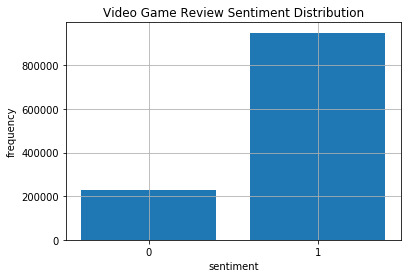

In [52]:
x = [1,2]
y = [video_game_review[(video_game_review['sentiment'] == 0)].count()[0],
     (len(video_game_review)-video_game_review[(video_game_review['sentiment'] == 0)].count()[0])]

labels = list(np.unique(video_game_review['sentiment']))

plt.bar(x, y, align='center')
plt.xticks(x, labels)
plt.xlabel('sentiment')
plt.ylabel('frequency')
plt.title('Video Game Review Sentiment Distribution')
plt.grid(True)
plt.show()

This time, instead of undersampling, we use oversampling from the minority class. The reason is that we wanted the amount of __video game review__ to be as similar as that of __Yelp review__ for a fair comparison. In fact, __Yelp review__ data was a bit larger, so we choose to oversample for __video game review__ data. Here, to prevent overfitting, we first separate data into positive and negative sentiment. Then we obtain 20% of each sentiment to set aside test dataset.

In [53]:
# train / test set split to prevent overfitting
video_game_review_pos = video_game_review[video_game_review['sentiment'] == 1]
video_game_review_neg = video_game_review[video_game_review['sentiment'] == 0]
video_game_review_pos = video_game_review_pos.reset_index(drop=True)
video_game_review_neg = video_game_review_neg.reset_index(drop=True)

np.random.seed(1)
indices = video_game_review_pos.index.tolist()
np.random.shuffle(indices)

train_indices = indices[:int(len(video_game_review_pos)*0.8)]
test_indices = indices[int(len(video_game_review_pos)*0.8):]

video_game_review_pos_train = video_game_review_pos.iloc[train_indices,:].reset_index(drop=True)
video_game_review_pos_test = video_game_review_pos.iloc[test_indices,:].reset_index(drop=True)

np.random.seed(1)
indices = video_game_review_neg.index.tolist()
np.random.shuffle(indices)

train_indices = indices[:int(len(video_game_review_neg)*0.8)]
test_indices = indices[int(len(video_game_review_neg)*0.8):]

video_game_review_neg_train = video_game_review_neg.iloc[train_indices,:].reset_index(drop=True)
video_game_review_neg_test = video_game_review_neg.iloc[test_indices,:].reset_index(drop=True)

video_game_review_train = pd.concat([video_game_review_neg_train, video_game_review_pos_train]).reset_index(drop=True)
video_game_review_test = pd.concat([video_game_review_neg_test, video_game_review_pos_test]).reset_index(drop=True)

Oversample negative sentiment from train data.

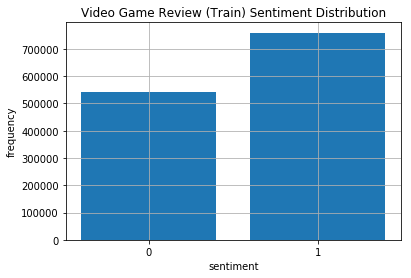

In [54]:
# oversampling negative sentiment from train data
video_game_review_train_pos = video_game_review_train[video_game_review_train['sentiment'] == 1]
video_game_review_train_neg = video_game_review_train[video_game_review_train['sentiment'] == 0]

video_game_review_train_neg2 = video_game_review_train_neg.copy()
video_game_review_train_neg3 = video_game_review_train_neg.copy()
video_game_review_train_neg = pd.concat([video_game_review_train_neg,
                                         video_game_review_train_neg2,
                                         video_game_review_train_neg3]).reset_index(drop=True)

video_game_review_train = pd.concat([video_game_review_train_neg, video_game_review_train_pos]).reset_index(drop=True)

x = [1,2]
y = [video_game_review_train[(video_game_review_train['sentiment'] == 0)].count()[0],
     (len(video_game_review_train)-video_game_review_train[(video_game_review_train['sentiment'] == 0)].count()[0])]

labels = list(np.unique(video_game_review_train['sentiment']))

plt.bar(x, y, align='center')
plt.xticks(x, labels)
plt.xlabel('sentiment')
plt.ylabel('frequency')
plt.title('Video Game Review (Train) Sentiment Distribution')
plt.grid(True)
plt.show()

The proportion looks much better now. We continue the pre-processing just like before.

In [55]:
### case conversion
#video_game_review_train['converted_review'] = video_game_review_train['review'].str.lower()
#converted_review = list(video_game_review_train['converted_review'])

### expanding contractions
#contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
#def expand_contractions(s, contraction_dict=contraction_dict):
#     def replace(match):
#         return contraction_dict[match.group(0)]
#     return contraction_re.sub(replace, s)

#for i in range(0,len(converted_review)):
#    converted_review[i] = expand_contractions(converted_review[i])

### removing special characters
#converted_review = [remove_special_characters(sentence) for sentence in converted_review]

#video_game_review_train['converted_review'] = pd.Series(converted_review)

#pickle.dump(video_game_review_train, open('video_game_review_train.pkl', 'wb'))
video_game_review_train = pickle.load(open('video_game_review_train.pkl', 'rb'))
video_game_review_train.head(10)

,review,rating,sentiment,converted_review
0,Graphics are of poor quality and the games are...,1,0,graphics are of poor quality and the games are...
1,I have played ALL the NFS games since PS1. I h...,1,0,i have played all the nfs games since ps1 i ha...
2,All I wanted was a stand along game like Civ 3...,1,0,all i wanted was a stand along game like civ 3...
3,game not here scratched so bad it said no game...,1,0,game not here scratched so bad it said no game...
4,This game has stripped out so much of what the...,1,0,this game has stripped out so much of what the...
5,I'm not sure how the other workout games for K...,1,0,i am not sure how the other workout games for ...
6,I couldn't see the purpose in Rhem 1 so I gues...,1,0,i could not see the purpose in rhem 1 so i gue...
7,"This game is terrible! NBA Live 97, 98, 99......",2,0,this game is terrible nba live 97 98 99 ea sp...
8,Bottom line is game cube and xbox are better. ...,1,0,bottom line is game cube and xbox are better 1...
9,When it has came down to rechargeable battery ...,2,0,when it has came down to rechargeable battery ...


Tokenize and get tf-idf dictionary.

In [56]:
# construct TF-IDF Matrix with true label column
tfidf_vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=stop_words_set, max_df=0.8, min_df=0.01)
#video_game_tfidf_vect_fit = tfidf_vectorizer.fit(video_game_review_train['converted_review'])
#pickle.dump(video_game_tfidf_vect_fit, open('video_game_tfidf_vect_fit.pkl', 'wb'))
video_game_tfidf_vect_fit = pickle.load(open('video_game_tfidf_vect_fit.pkl', 'rb'))
tfidf_sparse = video_game_tfidf_vect_fit.transform(video_game_review_train['converted_review'])
tfidf_dense = tfidf_sparse.todense(order=None, out=None)
tfidf_dense = pd.DataFrame(tfidf_dense)
tfidf_dense['y'] = video_game_review_train['sentiment']
tfidf_dense.head(10)

,0,1,2,3,4,5,6,7,8,9,...,724,725,726,727,728,729,730,731,732,y
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
5,0.0,0.277651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
8,0.0,0.118212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.688316,0.0,0.0,0.0,0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.209861,0.387136,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0


In [57]:
np.sort(list(video_game_tfidf_vect_fit.vocabulary_.keys()))

array(['10', '100', '12', '15', '20', '30', '360', '3d', '50', '60',
       'ability', 'able', 'absolutely', 'acting', 'action', 'actual',
       'actually', 'add', 'added', 'addition', 'adds', 'adventure', 'age',
       'ago', 'ai', 'allow', 'allows', 'alot', 'amazing', 'amazon',
       'annoying', 'anymore', 'arcade', 'area', 'areas', 'arrived', 'ask',
       'aspect', 'attack', 'available', 'avoid', 'away', 'awesome',
       'awful', 'bad', 'ball', 'based', 'basic', 'basically', 'batteries',
       'battery', 'battle', 'battles', 'beat', 'beautiful', 'beginning',
       'believe', 'best', 'better', 'big', 'biggest', 'bit', 'black',
       'blast', 'blue', 'board', 'bored', 'boring', 'boss', 'bother',
       'bought', 'box', 'brand', 'break', 'bring', 'broke', 'broken',
       'bucks', 'bugs', 'build', 'button', 'buttons', 'buy', 'buying',
       'cable', 'called', 'came', 'camera', 'campaign', 'car', 'card',
       'care', 'cars', 'case', 'cause', 'cd', 'certain', 'certainly',
     

In [58]:
term_weights = pd.DataFrame(video_game_tfidf_vect_fit.idf_, np.sort(list(video_game_tfidf_vect_fit.vocabulary_.keys())))
term_weights = term_weights.rename(columns={0: 'weights'})
term_weights.sort_values(by=['weights'], ascending=False).head(15)

,weights
sold,5.603335
ball,5.603181
fully,5.601497
ask,5.600885
wars,5.600274
types,5.599357
damage,5.599204
replacement,5.594711
sorry,5.593496
awful,5.593421


In [59]:
tfidf_dense_X = tfidf_dense.iloc[:,:-1]
tfidf_dense_y = tfidf_dense.iloc[:,-1]

np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(tfidf_dense_X, tfidf_dense_y, test_size=0.2)

#video_game_tfidf_rf_fit = rf_classifier.fit(X_train, y_train)
#pickle.dump(video_game_tfidf_rf_fit, open('video_game_tfidf_rf_fit.pkl', 'wb'))
video_game_tfidf_rf_fit = pickle.load(open('video_game_tfidf_rf_fit.pkl', 'rb'))

In [60]:
# misclassification rate
len(np.where(y_test != video_game_tfidf_rf_fit.predict(X_test))[0]) / len(y_test)

0.06539799295152832

In [61]:
# mean accuracy of the model
video_game_tfidf_rf_fit.score(X_test, y_test)

0.9346020070484716

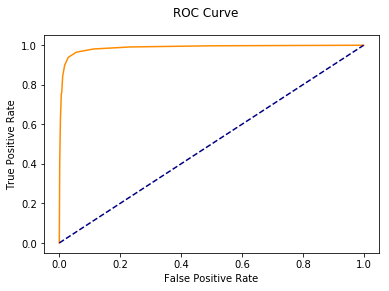

In [62]:
from sklearn import metrics
prob_value = video_game_tfidf_rf_fit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_value)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.suptitle('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [63]:
# AUC
roc_auc_score(y_test, video_game_tfidf_rf_fit.predict(X_test))

0.9413228602165223

In [64]:
# F1 score
f1_score(y_test, video_game_tfidf_rf_fit.predict(X_test), average='weighted')

0.9349880255644089

We apply the model to the test dataset and obtain various scores.

In [65]:
# transform text data in test set
#video_game_review_test['converted_review'] = video_game_review_test['review'].str.lower()
#converted_review = list(video_game_review_test['converted_review'])
#converted_review = [remove_special_characters(sentence) for sentence in converted_review]
#video_game_review_test['converted_review'] = pd.Series(converted_review)

#pickle.dump(video_game_review_test, open('video_game_review_test.pkl', 'wb'))
video_game_review_test = pickle.load(open('video_game_review_test.pkl', 'rb'))

In [66]:
# construct TF-IDF Matrix with true label column
tfidf_sparse = video_game_tfidf_vect_fit.transform(video_game_review_test['converted_review'])
tfidf_dense = tfidf_sparse.todense(order=None, out=None)
tfidf_dense = pd.DataFrame(tfidf_dense)
tfidf_dense['y'] = video_game_review_test['sentiment']

In [67]:
# misclassification rate
X_test = tfidf_dense.iloc[:,:-1]
y_test = tfidf_dense.iloc[:,-1]
len(np.where(y_test != video_game_tfidf_rf_fit.predict(X_test))[0]) / len(y_test)

0.13936535345329892

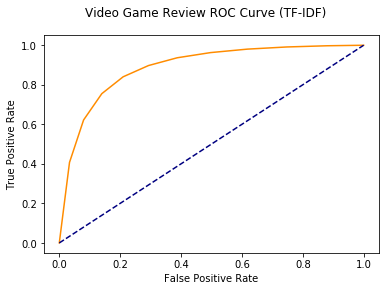

In [68]:
prob_value = video_game_tfidf_rf_fit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_value)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.suptitle('Video Game Review ROC Curve (TF-IDF)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [69]:
# AUC
roc_auc_score(y_test, video_game_tfidf_rf_fit.predict(X_test))

0.802141701372415

In [70]:
# F1 score
f1_score(y_test, video_game_tfidf_rf_fit.predict(X_test), average='weighted')

0.8639767593191527

### 2. Parsimonious Rule-Based Model Approach

The following codes are exactly the same as our previous __Parsimonious Rule-Based Model__ for __Yelp review__ data.

In [72]:
VADER_video_game_review = video_game_review_test.copy()

In [73]:
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#analyzer = SentimentIntensityAnalyzer()
#def sentiment_analyzer(x):
#    x = analyzer.polarity_scores(x).get('compound')
#    return x
#VADER_video_game_review['polarity_score'] = np.vectorize(sentiment_analyzer)(VADER_video_game_review['review'])

In [74]:
#def normalize(x):
#    x = (x+1)/2
#    return x
#VADER_video_game_review['normalized_polarity_score'] = np.vectorize(normalize)(VADER_video_game_review['polarity_score'])

In [75]:
#def VADER_sentiment(x):
#    if x > 0.5:
#        y = 1
#    elif x == 0.5:
#        if np.random.uniform(0,1) >= 0.5:
#            y = 1
#        else:
#            y = 0
#    else:
#        y = 0
#    return y
#VADER_video_game_review['predicted_sentiment'] = np.vectorize(VADER_sentiment)(VADER_video_game_review['normalized_polarity_score'])

In [76]:
#pickle.dump(VADER_video_game_review, open('VADER_video_game_review.pkl', 'wb'))
VADER_video_game_review = pickle.load(open('VADER_video_game_review.pkl', 'rb'))
VADER_video_game_review.head(10)

,review,rating,sentiment,converted_review,polarity_score,normalized_polarity_score,predicted_sentiment
0,I want a strategy guide tell me where i can a...,1,0,i want a strategy guide tell me where i can a...,0.0772,0.53860,1
1,"Awful. Do not buy, it's not worth the time or ...",1,0,awful do not buy its not worth the time or mon...,-0.2154,0.39230,0
2,Not sure what the target audience is for this ...,1,0,not sure what the target audience is for this ...,-0.0675,0.46625,0
3,The Xbox works (so far) but due to Xbox server...,1,0,the xbox works so far but due to xbox server i...,-0.5157,0.24215,0
4,I received the Tiger Woods PGA Tour 12: The Ma...,1,0,i received the tiger woods pga tour 12 the mas...,0.6696,0.83480,1
5,I didn't have a chance to play the game so tha...,1,0,i didnt have a chance to play the game so that...,-0.3669,0.31655,0
6,After 7 hours of trying to just install this g...,1,0,after 7 hours of trying to just install this g...,-0.1494,0.42530,0
7,Releasing this game at $59 / $49 price point s...,1,0,releasing this game at 59 49 price point shou...,-0.9435,0.02825,0
8,"I purchased this product. Used it once, tried ...",1,0,i purchased this product used it once tried to...,-0.5244,0.23780,0
9,I was going blind playing this version of COD....,1,0,i was going blind playing this version of codo...,-0.7882,0.10590,0


In [77]:
# misclassification rate
len(np.where(VADER_video_game_review['sentiment'] != VADER_video_game_review['predicted_sentiment'])[0]) / len(VADER_video_game_review)

0.16342084781157096

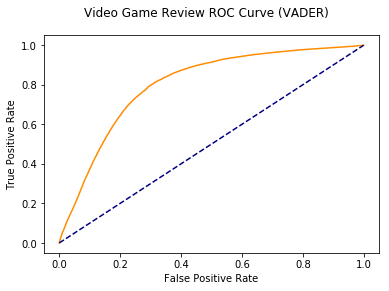

In [78]:
# ROC curve
prob_value = VADER_video_game_review['normalized_polarity_score']
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_value)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.suptitle('Video Game Review ROC Curve (VADER)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [79]:
y_true = list(VADER_video_game_review['sentiment'])
y_pred = list(VADER_video_game_review['predicted_sentiment'])

In [80]:
# AUC score
roc_auc_score(y_true, y_pred)

0.7020845949681173

In [81]:
# F1 score
f1_score(y_true, y_pred, average='weighted')

0.830061976659616

The below is a table with scores. Again, __TF-IDF Model__ worked better than __Parsimonious Rule-Based Model__.

<br>

|             |Video Game Review (TF-IDF)|Video Game Review (VADER)|
|:-----------:|:------------------------:|:-----------------------:|
|  error rate |           0.139          |          0.163          |
|     AUC     |           0.802          |          0.702          |
|F1 (weighted)|           0.864          |          0.830          |
<br>
<br>

Let's put everything together and do final comparison between two models on two datasets.

<br>

|              |Yelp Review (TF-IDF)|Yelp Review (VADER)|Video Game Review (TF-IDF)|Video Game Review (VADER)|
|:------------:|:------------------:|:-----------------:|:------------------------:|:-----------------------:|
|  error rate  |        0.112       |       0.213       |           0.139          |          0.163          |
|      AUC     |        0.883       |       0.727       |           0.802          |          0.702          |
| F1 (weighted)|        0.888       |       0.766       |           0.864          |          0.830          |
<br>
<br>

## Conclusion

First of all, an odd thing we notice is that the __Parsimonious Rule-Based Model__ actually performed better on __video game review__, which is unexpected. We thought it would not work as well as on __Yelp review__ since some of the game-related technical words such as *kill*, *die*, *destroy* could be used to express positive sentiment. In general, these words are supposed to be used to express negative sentiment. We think that the 5 general rules have a significant impact on its generalizability.
<br>
<br>
__TF-IDF__ is currently considered one of the most standard approaches to text mining. The performance metric (even without fine-parameter-tuning) clearly showed why it is considered the industry standard. However, we emphasize the achievement of __Parsimonious Rule-Based Model__ by comparing it with disadvantages of __TF-IDF Model__.
<br>
<br>
Disadvantages of __TF-IDF__ (Advantages of __Parsimonious Rule-Based Model__)
<br>
1. Does not take structure of words (grammar or idioms) into account.
2. Hard to interpret (black-box).
3. Scalability (fast enough to be used online with streaming data).
4. Less of speed-performance tradeoff.

We, especially, want to emphasize the interpretability part. For further improvement, having an interpretable model is very important. Without interpretable models, if something goes wrong, we might have to start building a new model from scratch, which is definitely not desirable. Also, the computational aspect should be mentioned. Because of kernel death problem, we couldn't use *Pipeline* to fine-tune parameters of *TfidfVectorizer* and *RandomForestClassifier*. However, based on our experiment, the tuning would easily take multiple hours, while __Parsimonious Rule-Based Model__ took about 15 minutes for the entire process. While more and more sophisticated versions of machine learning algorithms are prevailing in data science, this is a great example where we can see the benefits of human-centric approach and the limitations of black-box machine learning approach.

-----------------------------------------------

__Appendix (some examples of 5 generalizable heuristics)__
<br>
<br>
We think that it's worth presenting some examples that show the strengths of __Parsimonious Rule-Based Model__. __TF-IDF Model__ wouldn't be able to pick up the differences between the following examples, while __Parsimonious Rule-Based Model__ can accurately catch and score the right sentiment measures.

It considers tri-gram preceding sentiment-laden lexical feature.
<br>
For example, __never been vs. never been this__ or __shit vs. the shit__

In [82]:
sentence = 'My life has never been good.'
analyzer.polarity_scores(sentence)

{'compound': -0.3412, 'neg': 0.325, 'neu': 0.675, 'pos': 0.0}

In [83]:
sentence = 'My life has never been this good.'
analyzer.polarity_scores(sentence)

{'compound': 0.5228, 'neg': 0.0, 'neu': 0.64, 'pos': 0.36}

In [84]:
sentence = 'PSTAT 234 is shit!!'
analyzer.polarity_scores(sentence)

{'compound': -0.6351, 'neg': 0.582, 'neu': 0.418, 'pos': 0.0}

In [85]:
sentence = 'PSTAT 234 is the shit!!'
analyzer.polarity_scores(sentence)

{'compound': 0.6792, 'neg': 0.0, 'neu': 0.466, 'pos': 0.534}

It also considers different weights for pre-conjunction and post-conjunction.

In [86]:
sentence = 'I loved the food, but I hated their staff.'
analyzer.polarity_scores(sentence)

{'compound': -0.6542, 'neg': 0.438, 'neu': 0.377, 'pos': 0.185}

In [87]:
sentence = 'I hated their staff, but I loved the food.'
analyzer.polarity_scores(sentence)

{'compound': 0.5789, 'neg': 0.201, 'neu': 0.386, 'pos': 0.413}

__Reference__

Special thanks to Julian McAuley, *Assistant Professor*, Computer Science Department @ UCSD
<br>
<br>
R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016.
<br>
J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015.
<br>
Hutto, C.J. & Gilbert, Eric. (2015). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Proceedings of the 8th International Conference on Weblogs and Social Media, ICWSM 2014. 